<a href="https://colab.research.google.com/github/VGODIE/ML_kaggle_competitions/blob/master/IDAO_Lipatov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


In [0]:
import seaborn as sns

In [0]:
print(tf.__version__)

2.1.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/train.csv")

In [0]:
data.head(2)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468


In [0]:
freq = np.unique(data.sat_id.values, return_counts=True)[1]
#split = (freq*0.8).apply_along_axis(lambda x: int(x))

# Data visualization

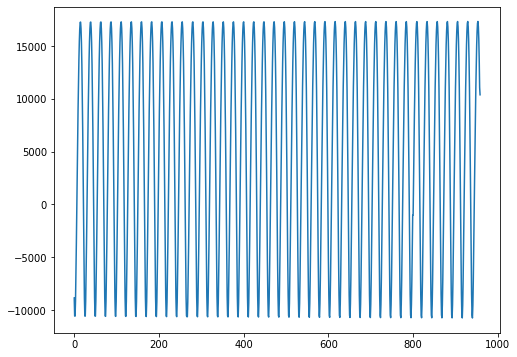

In [0]:
#plt.subplot(target.x[:freq[0] + 1])
plt.plot(target.x[:freq[0] + 1])
#plt.plot(target.y[:freq[0] + 1])
#plt.plot(target.z[:freq[0] + 1])

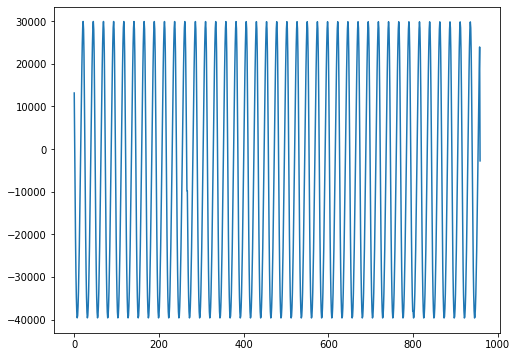

In [0]:
plt.plot(target.y[:freq[0] + 1])

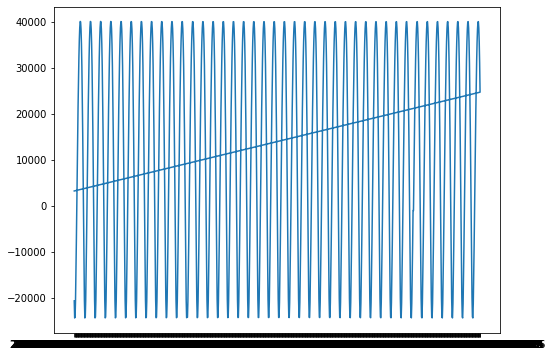

In [0]:
plt.plot(target.z[:freq[0] + 1])

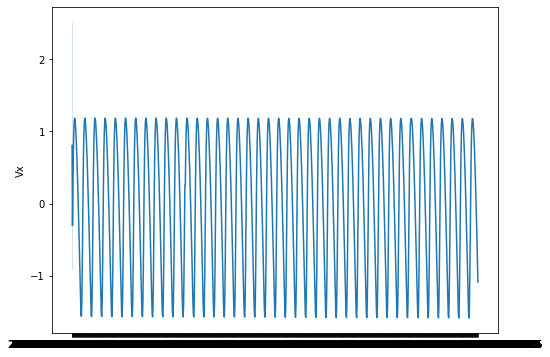

In [0]:
sns.lineplot(data.epoch.values[:freq[0] + 1] , target.Vx[:freq[0] + 1])

In [0]:
target.Vy[:freq[0] + 1]

In [0]:
target.Vz[:freq[0] + 1]

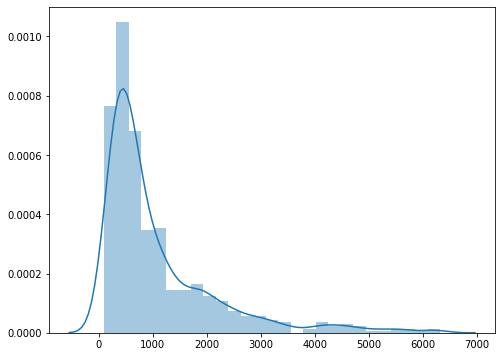

In [0]:
import seaborn as sns
sns.distplot(freq)

# Data preprocessing

In [0]:
del data_real_scaled

In [0]:
from sklearn.preprocessing import StandardScaler

data_real = data[["x", "y", "z", "Vx", "Vy", "Vz"]].values
scaler = StandardScaler()
data_real = scaler.fit_transform(data_real)

In [0]:
from sklearn.preprocessing import StandardScaler

data_sim = data[["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]].values

In [0]:
cos_sin = np.concatenate((np.sin(data_sim), np.cos(data_sim)), axis=1)

Massive preprocessing for time series
Skip if u want ot test another model

In [0]:
data_sim.shape

(649912, 6)

Сделаем кнн предсказания для каждого наблюдения и добавим их как новые 6 регрессоров

In [0]:
from sklearn.neighbors import KNeighborsRegressor
knn_list = []
for i in range(6):
    knn = KNeighborsRegressor()
    knn.fit(data_sim, data_real[:,i])
    knn_list.append(knn)
    if i == 0:
      ktr_preds = knn.predict(data_sim).reshape(-1, 1)
    else:
      ktr_preds = np.concatenate((ktr_preds, knn.predict(data_sim).reshape(-1, 1)), axis=1)

In [0]:
data_sim = np.concatenate((data_sim, ktr_preds), axis=1)
del ktr_preds

In [0]:
scaler_sim = StandardScaler()
data_sim = scaler_sim.fit_transform(data_sim)
data_sim = np.concatenate((data_sim, cos_sin), axis=1)
del cos_sin

In [0]:
def cut(data, freq):
  start = 0
  end = freq[0]
  arr = []
  for i in range(len(freq)):
    arr.append(data[start:end])
    start = end
      
    if i != len(freq) - 1:
      end += freq[i+1]
  return arr

In [0]:
data_real.shape

(649912, 6)

In [0]:
cut_data_sim = cut(data_sim, freq)
cut_data_real = cut(data_real, freq)
len(cut_data_real) == len(cut_data_sim)

True

In [0]:
window_size = 35


In [0]:
def get_window_data(data_sim, window, data_real=None, train=True):
    # Get window data and scale
    #scaler_sim = MinMaxScaler(feature_range=(0, 1))
    #scaler_real = MinMaxScaler(feature_range=(0, 1))

    X = []
    y = []

    for i in range(len(data_sim) - window):
        X.append(data_sim[i : i + window])
        if train == True:
          y.append(data_real[i + window])

    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [0]:
for i in range(len(cut_data_sim)):
  regressor, target = get_window_data(cut_data_sim[i], window_size, cut_data_real[i])
  if i == 0:
    q = regressor
    w = target
  else:
    q = np.concatenate((q, regressor))
    w = np.concatenate((w, target))
  del regressor
  del target

In [0]:
del all_x
del all_y
del cut_data_real

In [0]:
q.shape

# Model architecture

In [0]:
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [0]:
np.random.seed(42)

In [0]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_sim, data_real)
X_train_sc ,X_test_sc, y_train_scaled, y_test_scaled = train_test_split(data_sim, data_scaled)

### Linear regression

In [0]:
def train_linreg(x_train, y_train, x_test, y_test):
  for i in range(6):
    lr = LinearRegression()
    lr.fit(x_train, y_train[:,i])
    if i ==0:
      lr_preds = lr.predict(x_test).reshape(-1,1)
    else:
      lr_preds = np.concatenate((lr_preds, lr.predict(x_test).reshape(-1,1)), axis=1)

  print("smape =", smape(lr_preds, y_test))

Сначала без скейлинга таргета

In [0]:
train_linreg(X_train, y_train, X_test, y_test)

smape = 0.04181814786857531


Теперь с norme скейлингом

In [0]:
train_linreg(X_train_sc, y_train_scaled, X_test_sc, y_test_scaled, 6)

smape = 0.22862262065880565


Добавим квадратичные признаки

In [0]:
data_sim = np.concatenate((data_sim, data_sim**2), axis=1)

X_train, X_test, y_train, y_test = train_test_split(data_sim, data_real)
X_train_sc ,X_test_sc, y_train_scaled, y_test_scaled = train_test_split(data_sim, data_scaled)

In [0]:
print("without scaling")
train_linreg(X_train, y_train, X_test, y_test)
print('\n')
print("with scaling")
train_linreg(X_train_sc, y_train_scaled, X_test_sc, y_test_scaled)

without scaling
smape = 0.22928967279698123


with scaling
smape = 0.22861719952727963


Добавим синус и косинус

In [0]:
data_sim = np.concatenate((data_sim, np.cos(data_sim)), axis=1)
data_sim = np.concatenate((data_sim, np.sin(data_sim)), axis=1)

X_train, X_test, y_train, y_test = train_test_split(data_sim, data_real)
X_train_sc ,X_test_sc, y_train_scaled, y_test_scaled = train_test_split(data_sim, data_scaled)

print("without scaling")
train_linreg(X_train, y_train, X_test, y_test)
print('\n')
print("with scaling")
train_linreg(X_train_sc, y_train_scaled, X_test_sc, y_test_scaled)

without scaling
smape = 0.22567926828094492


with scaling
smape = 0.225971629925241


In [0]:
data_sim = data[["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]].values
data_sim = np.concatenate((data_sim, data_sim**2), axis=1)
data_sim = np.concatenate((data_sim, np.cos(data_sim[:,:6])), axis=1)
data_sim = np.concatenate((data_sim, np.sin(data_sim[:,:6])), axis=1)

In [0]:
scaler_sim = StandardScaler()
data_sim_scaled = scaler_sim.fit_transform(data_sim)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_sim_scaled, data_real)

In [0]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, GRU
from tensorflow.keras import Sequential

In [0]:
#test_split = int(len(q) * 0.8)
test_split = (len(w) - freq[-1] - freq[-2])
print(test_split)
#X_train = q[:test_split]
#X_test = q[test_split:]

#y_train = w[:test_split]
#y_test = w[test_split:]

X_train = q[:test_split]
X_test = q[test_split:]

y_train = w[:test_split]
y_test = w[test_split:]

626467


In [0]:
test_split

626467

In [0]:
model = tf.keras.models.load_model("model_one.hdf5")

In [0]:
# ------- Building the LSTM model --------- #
adam = tf.keras.optimizers.Adam(amsgrad=True, clipvalue=1.0)
adagrad = tf.keras.optimizers.Adagrad(clipvalue=1.0)

model = Sequential()
model.add(Bidirectional(GRU(100,return_sequences=True, input_shape=(window_size, X_train.shape[-1])))) # 50neurons, and and window_size = 50 
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(75)))
model.add(Dropout(0.3))
model.add(Dense(6))
model.compile(loss="mean_squared_error", optimizer= adam)

In [0]:
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_test, y_test))

Train on 626467 samples, validate on 2445 samples
Epoch 1/20
626467/626467 [==============================] - 59s 94us/sample - loss: 0.0494 - val_loss: 0.0024
Epoch 2/20
626467/626467 [==============================] - 49s 78us/sample - loss: 0.0261 - val_loss: 0.0014
Epoch 3/20
626467/626467 [==============================] - 49s 78us/sample - loss: 0.0241 - val_loss: 0.0017
Epoch 4/20
626467/626467 [==============================] - 49s 78us/sample - loss: 0.0232 - val_loss: 0.0013
Epoch 5/20
626467/626467 [==============================] - 48s 77us/sample - loss: 0.0227 - val_loss: 0.0013
Epoch 6/20
626467/626467 [==============================] - 45s 72us/sample - loss: 0.0223 - val_loss: 0.0016
Epoch 7/20
626467/626467 [==============================] - 47s 76us/sample - loss: 0.0221 - val_loss: 0.0013
Epoch 8/20
626467/626467 [==============================] - 48s 76us/sample - loss: 0.0218 - val_loss: 0.0015
Epoch 9/20
626467/626467 [==============================] - 47s 76us/s

In [0]:
from tensorflow.keras.models import save_model

model.save("model_one.hdf5")

In [0]:
preds = model.predict(X_test)

In [0]:
invpreds = scaler.inverse_transform(preds)
invtarget = scaler.inverse_transform(y_test)
smape(invpreds, invtarget)

0.06035810643100558

In [0]:
smape(preds, y_test)

0.06108911685877551

In [0]:
def plot_history(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history["loss"],  label="Train")
    plt.plot(history.history["val_loss"], label="Test")
    plt.title("Loss over epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

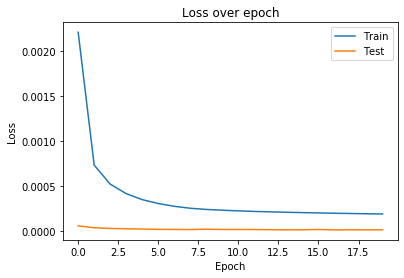

In [0]:
plot_history(history)

In [0]:
preds[:,0].shape

(2445,)

In [0]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
def plot(X_test):
    pred = model.predict(X_test)
    pred_inverse = scaler_sim.inverse_transform(pred.reshape(-1, 1))
    y_test_inverse = scaler_real.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate mean_squared_error. Previosly we did MinMax scale, so apply inverse_transform to recover values
    rmse = sqrt(mean_squared_error(y_test_inverse, pred_inverse))
    print('Test RMSE: %.3f' % rmse)
    plt.figure(figsize=(15, 8))
    plt.plot(pred_inverse, label='predict')
    plt.plot(y_test_inverse, label='actual')
    plt.legend()
    plt.show()

In [0]:
plot(X_test)

##Gradient boosting 

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

In [0]:
import xgboost as xgb

In [0]:
X_train.shape[0] == y_train.shape[0]

True

In [0]:
boost_list = []
for i in range(6):
  boost = GradientBoostingRegressor(loss = "huber", learning_rate=0.2, verbose=1, subsample=0.5)
  boost.fit(X_train, y_train[:,i])
  if i ==0:
    preds_lst = boost.predict(X_test).reshape(-1,1)
  else:
    preds_lst = np.concatenate((preds_lst, boost.predict(X_test).reshape(-1,1)), axis=1)
  boost_list.append(boost)

In [0]:
bst_list = []
for i in range(6):
  bst = xgb.XGBRegressor(learning_rate=0.2, subsample=0.7, verbosity=2 )
  bst.fit(X_train, y_train[:,i], verbose=True)
  if i == 0:
    preds_arr = bst.predict(X_test).reshape(-1,1)
  else:
    preds_arr = np.concatenate((preds_arr, bst.predict(X_test).reshape(-1,1)), axis=1)
  bst_list.append(bst)


In [0]:
np.mean(X_train, axis=0)

array([-4.26594396e-04, -9.38527660e-04, -8.89313282e-04,  1.73509790e-04,
        7.08442611e-04,  1.07574076e-03, -7.09666220e-04,  2.72612001e-05,
        2.54346033e-04, -1.03012709e-03, -1.55658553e-04,  1.40345972e-03,
       -6.01692909e-05,  7.30487501e-05, -3.11542280e-04,  6.56181584e-04,
       -3.04548882e-04, -1.51600066e-03,  1.76794752e-04, -1.70919038e-04,
        3.52958511e-04,  1.07385790e-03, -1.28957759e-03,  1.33199238e-04])

In [0]:
bst_x = xgb.XGBRegressor(learning_rate=0.2,loss="reg:squarederror", subsample=0.5, verbosity=2, n_estimators=150, reg_lambda=1)
bst_x.fit(X_train, y_train[:,0])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:22:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:22:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:22:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:22:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:22:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:22:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:22:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, loss='reg:squarederror',
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=150, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, verbosity=2)

In [0]:
smape(bst_x.predict(X_train), y_train[:,0])


0.2013370912695377

In [0]:
for i in range(6):
  print(smape(boost_list[i].predict(X_train), y_train[:,i]))

0.18619006397810367
0.19481945754496796
0.20291636271497085
0.1971085299029239
0.2027304741381391
0.21990640857460575


In [0]:
boost_x = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=7, subsample=0.5,  verbose=1, random_state=42)
boost_x.fit(X_train, y_train[:,0])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1   523427967.3135   121188508.6940           18.97m
         2   423695462.4951    98499459.0050           19.11m
         3   346434403.6949    79337750.3662           18.94m
         4   280536356.9454    64455020.4575           18.87m
         5   230350913.4948    52053856.5084           18.74m
         6   187389265.0762    42027252.3336           18.67m
         7   152697676.3763    34169958.3782           18.65m
         8   124887149.4419    27616414.5230           18.59m
         9   101728365.2532    22477685.1083           18.50m
        10    83806757.4308    18195166.2448           18.41m
        20    14401710.5680     2250320.9192           17.06m
        30     5584667.3545      259211.0789           15.80m
        40     3992575.7584       30390.2053           14.52m
        50     3751534.4240       19192.2514           13.30m
        60     3389087.1316       -1437.6703           12.05m
       

In [0]:
smape(boost_x.predict(X_test), y_test[:,0])

In [0]:
smape(boost_x.predict(X_train), y_train[:,0])

In [0]:
sklearn.metrics.mean_squared_error(y_train[:,0], boost_x.predict(X_train))

27441264.274389137

In [0]:
boost_y = GradientBoostingRegressor(learning_rate=0.2, n_estimators=200, max_depth=5, subsample=0.5,  verbose=1)
boost_y.fit(X_train, y_train[:,2])


In [0]:
smape(boost_y.predict(X_test), y_test[:,2])

Проблема градиентного бустинга - для скоростей лосс остается довольно большим - нужно тюнить

In [0]:
preds_arr.shape == y_test.shape

True

In [0]:
smape(scaler_real.inverse_transform(preds_arr), scaler_real.inverse_transform(y_test))

0.21984405377475447

## Support vector regression

In [0]:
from sklearn.kernel_approximation import Nystroem

feature_map_nystroem = Nystroem(gamma=.2,random_state=1,n_components=300)
data_sim_transformed = feature_map_nystroem.fit_transform(data_sim)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_sim_transformed, data_real_scaled)

In [0]:
from sklearn.svm import LinearSVR

svr = LinearSVR(epsilon=1)
svr.fit(X_train, y_train[:,0])

LinearSVR(C=1.0, dual=True, epsilon=1, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [0]:
smape(svr.predict(X_train), y_train[:,0])

0.9584124191568774

## RandomForest

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=7,n_estimators=15, oob_score=True, verbose=1)
rf.fit(X_train, y_train[:,0])
rf_preds = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished


In [0]:
smape(rf_preds, y_test[:,0])

0.05552649026441422

# Downloading test data

In [0]:
test = pd.read_csv("/content/drive/My Drive/test.csv")

In [0]:
test.head(3)

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412


In [0]:
test_data = test[["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]].values

In [0]:
test_freq = np.unique(test.sat_id.values, return_counts=True)[1]
test_sat_id = np.unique(test.sat_id.values)

In [0]:
test_data.shape

(284071, 6)

In [0]:
for i in range(6):
    if i == 0:
      knn_preds_test = knn_list[i].predict(test_data).reshape(-1, 1)
    else:
      knn_preds_test = np.concatenate((knn_preds_test, knn_list[i].predict(test_data).reshape(-1, 1)), axis=1)

In [0]:
test_data = np.concatenate((test_data, knn_preds_test), axis=1)
test_data.shape

(284071, 12)

In [0]:
test_data = scaler_sim.transform(test_data)

In [0]:
#test_data = np.concatenate((test_data, test_data**2), axis=1)
test_data = np.concatenate((test_data, np.cos(test_data[:,:6])), axis=1)
test_data = np.concatenate((test_data, np.sin(test_data[:,:6])), axis=1) 

In [0]:
cut_test_data = cut(test_data, test_freq)

In [0]:
#forthetest!
for i,j in zip(test_sat_id, range(len(test_sat_id))):
  cut_test_data[j] = np.concatenate((cut_data_sim[i][-window_size:], cut_test_data[j]))

In [0]:
all_x_test = []
for i in range(len(cut_test_data)):
  regressor, _ = get_window_data(cut_test_data[i], window_size, train=False)
  all_x_test.append(regressor)

del regressor
del cut_test_data

In [0]:
q_test = all_x_test[0]
for i in range(1, len(all_x_test)):
  q_test = np.concatenate((q_test, all_x_test[i]))

del all_x_test

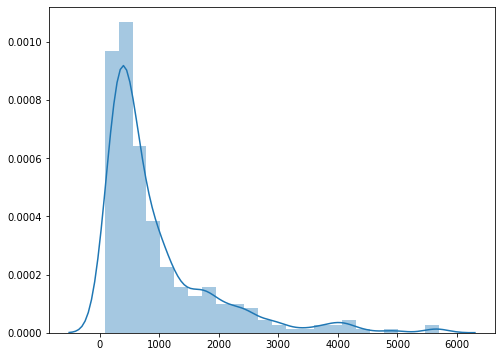

In [0]:
sns.distplot(test_freq)

In [0]:
q_test.shape[0] == len(test)

True

In [0]:
test_preds = model.predict(q_test)

In [0]:
#если делать через бустинг
for count, booster in enumerate(boost_list):
  if count == 0:
    test_preds = booster.predict(test_data).reshape(-1, 1)
  else:
    test_preds = np.concatenate((test_preds, booster.predict(test_data).reshape(-1,1)), axis=1)

In [0]:
test_preds.shape

(284071, 6)

In [0]:
np.mean(test_preds, axis=0)

array([0.55495175, 0.57856781, 0.47322224, 0.50427423, 0.40077906,
       0.51967696])

In [0]:
invscaled = scaler_real.inverse_transform(test_preds)

In [0]:
sub = pd.DataFrame(test_preds, columns=['x', 'y', 'z', 'Vx', 'Vy', 'Vz'])
sub["id"] = test.id

In [0]:
cols = sub.columns.to_list()
cols = cols[-1:] + cols[:-1]
sub = sub[cols]

In [0]:
sub.to_csv("subb.csv", index=False)

In [0]:
pd.read_csv("subb.csv")

,id,x,y,z,Vx,Vy,Vz
0,3927,-2109.892642,292.449431,-729.061327,2.219705,-0.107961,0.540094
1,3928,-2157.807278,-570.694448,-232.188841,2.037428,0.272408,0.200921
2,3929,-1861.921036,-1042.985420,-376.103936,2.151781,1.225171,-0.252781
3,3930,485.644846,-150.717719,460.781725,2.630969,1.782660,-0.621711
4,3931,-763.287466,-197.494688,1601.738092,1.362915,2.521799,-1.205368
...,...,...,...,...,...,...,...
284066,1231060,-2287.311390,-107.052880,12.597190,-0.107066,-0.106313,0.029697
284067,1231061,-2346.433044,-363.317769,12.597190,-0.190861,-0.009286,0.032700
284068,1231062,-2309.875712,-580.143413,-41.190737,-0.190861,0.357273,0.032700
284069,1231063,-2316.973991,-580.143413,-41.190737,0.101222,0.755977,-0.028559


# Идеи

1. Добавить предсказания кнн как признаки
2. Построить отдельные модели для каждой из таргетных переменных
3. Попробовать другой лосс
4. Добавить метрику смэйп в обучение в исходных масштабах
5. Продумать разбиение на траин-тест